In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pandas_datareader import data

def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

In [2]:
# response/target variable = future price of security
# response variable = future price - current price
# predict +/- and magnitude ie +10, -3
# X = Open-Close, High-Low
# Y = Close + 1 day - Close

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

# train, test, split
def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

In [3]:
# load data
goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

File data found...reading GOOG data


In [11]:
goog_data.head(2)

,High,Low,Open,Close,Volume,Adj Close,Open-Close,High-Low,Target,Predicted_Signal,GOOG_Returns
Date,,,,,,,,,,,
2004-08-19,51.835709,47.800831,49.813286,49.982655,44871300.0,49.982655,-0.169369,4.034878,3.970116,0.281273,NaN
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942800.0,53.952770,-3.636368,4.273979,0.542965,0.183888,0.076433


In [4]:
# create feature & target variable
goog_data, X, Y = create_regression_trading_condition(goog_data)

# train test split
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

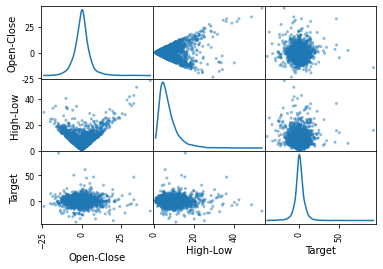

In [10]:
pd.plotting.scatter_matrix(goog_data[['Open-Close', 'High-Low', 'Target']], grid=True, diagonal='kde')
plt.show()

In [5]:
from sklearn import linear_model
# Fit the model
ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)

LinearRegression()

In [6]:
print('Coefficients: \n', ols.coef_)

goog_data['Predicted_Signal'] = ols.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))


Coefficients: 
 [[ 0.02410177 -0.05781461]]


                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2004-08-19  51.835709  47.800831  49.813286  49.982655  44871300.0  49.982655   
2004-08-20  54.336334  50.062355  50.316402  53.952770  22942800.0  53.952770   
2004-08-23  56.528118  54.321388  55.168217  54.495735  18342800.0  54.495735   
2004-08-24  55.591629  51.591621  55.412300  52.239193  15319700.0  52.239193   
2004-08-25  53.798351  51.746044  52.284027  52.802086   9232100.0  52.802086   

            Open-Close  High-Low    Target  Predicted_Signal  GOOG_Returns  
Date                                                                        
2004-08-19   -0.169369  4.034878  3.970116          0.281273           NaN  
2004-08-20   -3.636368  4.273979  0.542965          0.183888      0.076433  
2004-08-23    0.672482  2.206730 -2.256542          0.407256      0.010013  
2004-08-24    3.173107  4.000008  0.562893     

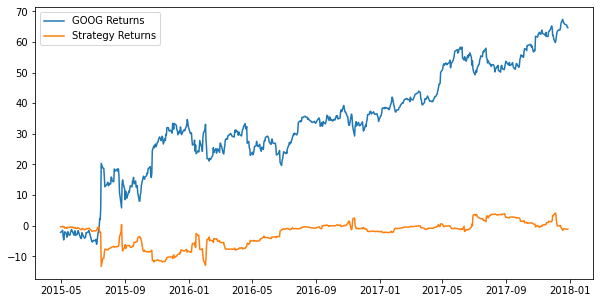

2.0840606780226096
Mean squared error: 27.52
Variance score: 0.00
Mean squared error: 103.50
Variance score: -0.01


In [10]:
print(goog_data.head())
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return


cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')


def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()


print(sharpe_ratio(cum_strategy_return, cum_goog_return))

from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, ols.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, ols.predict(X_train)))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, ols.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, ols.predict(X_test)))